## MNIST Classification / Generation using AUNN

## Setup & Definition

In [1]:
import torch
import random
import time
import torch.optim as optim
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#deallocate all cuda memory
torch.cuda.empty_cache()

#print cuda memory
print(torch.cuda.memory_allocated())

cuda
0


In [2]:
class AUNNModel(nn.Module):
    def __init__(
        self, 
        embedding_dim:int,
        output_dim:int, 
        num_layers:int, 
        hidden_dim:int):        

        assert num_layers >= 2, "Number of layers must be at least 2"

        super(AUNNModel, self).__init__() 
    
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Input Layer
        self.input_layer =  nn.Linear(self.embedding_dim, self.hidden_dim)

        # Hidden Layers
        self.layers = nn.ModuleList()
        for _ in range(self.num_layers - 2):  # Exclude input and output layers
            self.layers.append(nn.Sequential(
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.SiLU(),
                nn.RMSNorm(self.hidden_dim)
            ))

        # Output Layer
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Kaiming He initialization for Swish activation
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    # def embed(self, x: torch.Tensor):

    #     assert x.size(-1) == self.id_dim, "Input tensor must have the same number of dimensions as id_dim"
    #     encodings = []
    #     for i in range(x.size(-1)):
    #         encodings.append(self.encode(x[:, i]))
    #     output = torch.stack(encodings, dim=1)
    #     output = output.reshape(x.size(0), -1)
    #     return output

    # binary
    def encode(self, x: torch.Tensor):
        dim = self.embedding_dim
        encoding = ((x.unsqueeze(1) >> torch.arange(dim, device=x.device)) & 1).to(torch.float32)
        return encoding

    def forward(self, indices):
        
        x = self.encode(indices)
        x = self.input_layer(x)
        x = x + nn.SiLU()(x)

        for layer in self.layers:
            x = x + layer(x)  # MLP output with skip connection

        x = self.output_layer(x)
        return x

In [18]:
# Define a function to save the model checkpoint
def save_checkpoint(model, params, optimizer, losses, filename="checkpoint.pth"):
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'params':{}
    }

    keys = ['embedding_dim', 'output_dim', 'num_layers', 'hidden_dim']
    assert all(k in params for k in keys)
    for k in keys:
        checkpoint['params'][k] = params[k]

    torch.save(checkpoint, filename)
    print(f"Checkpoint saved with loss {losses[-1]:.4f}")

In [4]:
def load_checkpoint(filename="checkpoint.pth"):

    checkpoint = torch.load(filename, weights_only=True)
    
    params = checkpoint['params']
    model = AUNNModel(**params)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    optimizer = optim.AdamW(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    losses = checkpoint['losses']

    print(f"Checkpoint loaded: loss {losses[-1]:.4f}")

    return model, optimizer, losses

## Prepare MNIST

In [5]:
import struct
from array import array

def load_mnist(images_path, labels_path, shuffle:bool=False, binarize:bool=True, seed=42):

    labels = []
    with open(labels_path, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8)) 
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = array("B", file.read())

    images = []
    rows, cols = None, None
    with open(images_path, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        data = array("B", file.read())
        for i in range(size):
            img = np.array(data[i * rows * cols:(i + 1) * rows * cols], dtype=np.uint8)
            if binarize:
                img = np.where(img > 0, 1, 0) 
            img.resize((rows, cols))
            images.append(img)

    assert len(images) == len(labels)

    if shuffle:
        random.seed(seed)
        indices = list(range(len(images)))
        random.shuffle(indices)
        images = [images[i] for i in indices]
        labels = [labels[i] for i in indices]

    return images, labels


def encode_patches(img, N):
    """
    Encodes a (28x28) binary image into patches of size NxN.
    Each NxN patch (N^2 bits) is converted into a single integer 
    in [0..(2^(N^2)-1)].
    
    Returns a flattened 1D array of length (28//N)*(28//N).
    """
    # 1. Reshape: (dim//N, N, dim//N, N)
    # 2. Transpose to group NxN patches -> (28//N, 28//N, N, N)
    #    so each (i, j) index references one NxN patch
    h = w = img.shape[0]
    assert img.shape[0] == img.shape[1], "Image must be square."
    assert h % N == 0 and w % N == 0, "Image dimensions must be divisible by N."
    arr_NxN = img.reshape(h//N, N, w//N, N).transpose(0, 2, 1, 3)
    # shape: (h//N, w//N, N, N)

    # 3. Flatten NxN -> N^2 bits: shape becomes (h//N, w//N, N^2)
    arr_flat = arr_NxN.reshape(h//N, w//N, N*N)

    # 4. Multiply each bit by powers of 2 to combine into single integers
    #    For example, if N=2, bitweights = [1, 2, 4, 8].
    bitweights = np.array([1 << i for i in range(N*N)], dtype=arr_flat.dtype)
    encoded = (arr_flat * bitweights).sum(axis=-1)  # shape (h//N, w//N)

    # 5. Flatten to 1D array
    return encoded.ravel()


def decode_patches(encoded, N, dim=28):
    """
    Decodes a flattened array of integers (each representing N^2 bits)
    back to a (28x28) binary image with NxN patches.
    """
    h = w = dim
    num_patches = (h // N) * (w // N)
    
    # 1. Reshape from (num_patches,) -> (h//N, w//N)
    arr_2d = encoded.reshape(h//N, w//N)

    # 2. Extract bits for each integer using bitwise AND with [1, 2, 4, ..., 2^(N^2-1)]
    bitweights = np.array([1 << i for i in range(N*N)], dtype=np.uint16)
    # shape -> (h//N, w//N, N^2)
    bits = ((arr_2d[..., None] & bitweights) > 0).astype(np.uint16)

    # 3. Reshape bits back to NxN patches: (h//N, w//N, N, N)
    arr_patches = bits.reshape(h//N, w//N, N, N)

    # 4. Transpose to (h//N, N, w//N, N) then reshape to (h, w)
    arr_patches = arr_patches.transpose(0, 2, 1, 3)  # shape -> (h//N, N, w//N, N)
    decoded = arr_patches.reshape(h, w)

    return decoded


def make_string(images, labels):
    
    targets = []
    for img, label in zip(images, labels):

        #prep img data
        img = np.where(img > 0.1, 1, 0)  #binarize
        img = encode_patches(img, 2)

        #prep label data
        num_repeats = len(img) // 8
        label = np.array([label] * num_repeats, dtype=np.uint16)

        #add to target
        targets.append(label)
        targets.append(img)
        targets.append(label)

        #define lengths
        img_len = len(img)
        lbl_len = len(label)
        ex_len = img_len + lbl_len * 2

    targets = np.concatenate(targets, axis=0)
    return (ex_len, img_len, lbl_len), targets


In [6]:
from pathlib import Path

cur_dir = Path().resolve()
input_path = cur_dir / 'mnist'
training_images_filepath = input_path / 'train-images.idx3-ubyte'
training_labels_filepath = input_path /'train-labels.idx1-ubyte'
test_images_filepath = input_path / 't10k-images.idx3-ubyte'
test_labels_filepath = input_path / 't10k-labels.idx1-ubyte'

train_images, train_labels = load_mnist(training_images_filepath, training_labels_filepath, shuffle=True, binarize=False)
lengths, train_data  = make_string(train_images, train_labels)
print(f"{len(train_data):,} training samples")

14,640,000 training samples


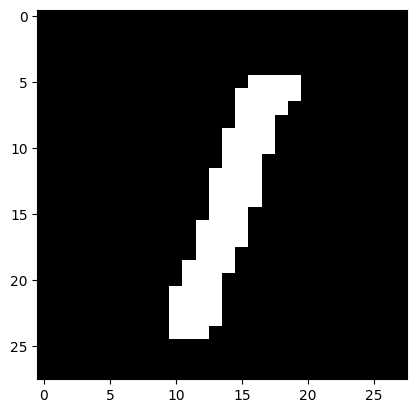

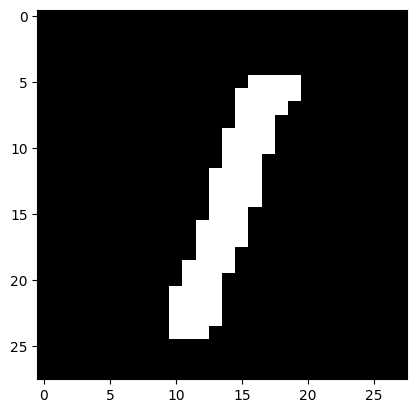

In [7]:
img = train_images[999]
img = np.where(img > 0.1, 1, 0)  #binarize
plt.imshow(img, cmap='gray')
plt.show()

enc = encode_patches(img, 2)

img = decode_patches(enc, 2)
plt.imshow(img, cmap='gray')
plt.show()

In [8]:
ex_len, img_len, lbl_len = lengths
print(f"Example length: {ex_len}, Image length: {img_len}, Label length: {lbl_len}")

Example length: 244, Image length: 196, Label length: 24


[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 12 12 12  0  0  0  0]
 [ 0  0  0  0  0  8 15 15  3 15  5  0  0  0]
 [ 0  0  0  0  0 10 15  1 10 15  5  0  0  0]
 [ 0  0  0  0  0 10 15  8 15 15  1  0  0  0]
 [ 0  0  0  0  0 10 15 15  7  1  0  0  0  0]
 [ 0  0  0  0  0 10 15 15  1  0  0  0  0  0]
 [ 0  0  0  0  0 14 15  5  0  0  0  0  0  0]
 [ 0  0  0  0 10 15 15 13  0  0  0  0  0  0]
 [ 0  0  0  0 14 15 10 15  0  0  0  0  0  0]
 [ 0  0  0  0 15 15 15 15  0  0  0  0  0  0]
 [ 0  0  0  0  2  3  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


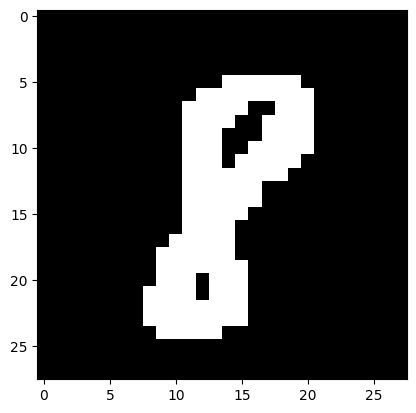

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


In [9]:
ex_num = 100
offset = ex_num * ex_len

#get label bytes
lbl_1 = train_data[offset:offset+lbl_len]
offset += lbl_len
print(lbl_1)

#get image bytes
img = train_data[offset:offset+img_len]
print(img.reshape(14, 14))
offset += img_len
img = decode_patches(img, 2)
plt.imshow(img, cmap='gray')
plt.show()

#get label bytes
lbl_2 = train_data[offset:offset+lbl_len]
print(lbl_2)

## Train

In [10]:
# Hyperparameters

embedd_dim = 32
num_layers = 12    # Must be even and at least 2 (bc of skip connections)
hidden_dim = 768   # Size of hidden layers
output_dim = 2**4  # bc N=2 patches
batch_size = 8192
num_epochs = 200

In [11]:
# Initialize the model, loss function, and optimizer

model = AUNNModel(
    embedding_dim=embedd_dim,
    output_dim=output_dim,
    num_layers=num_layers, 
    hidden_dim=hidden_dim).to(device)
print(f"Model has {model.count_params():,} parameters")

Model has 5,951,248 parameters


In [12]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [13]:
#DEBUG
# num_ex = len(train_labels)
num_ex = 1000
train_data = train_data[:num_ex*ex_len]
train_data = torch.tensor(train_data, dtype=torch.long).to(device)
print(f"train_data: {train_data.shape}")

train_data: torch.Size([244000])


In [14]:
losses = []
accuracies = []

In [15]:
# Training loop

num_batches = len(train_data) // batch_size
if len(train_data) % batch_size != 0:
    num_batches += 1

SHUFFLE_BATCHES = True
random.seed(40)

for epoch in tqdm(list(range(num_epochs))):
    batch_nums = list(range(num_batches))

    if SHUFFLE_BATCHES:
        random.shuffle(batch_nums)
    for batch_num in tqdm(batch_nums, leave=False, disable=False):

        start = batch_num * batch_size
        end = start + batch_size
        end = min(end, len(train_data))
        targets = train_data[start:end]

        #define absolute indices of data points
        abs_indices = torch.arange(start, end)
        #apply modulo ex_len to inputs, index relative to ex start
        data_indices = abs_indices % ex_len
        #apply floor division to inputs, index of current example
        ex_indices = abs_indices // ex_len
        #multiply ex_indices by 256 in order to align with power of 2
        assert 256 > ex_len
        ex_indices = ex_indices * 256
        #addd data_inds to ex_inds
        indices = ex_indices + data_indices
        #move to device
        indices = indices.to(device)
        
        # Forward pass
        outputs = model(indices)
        loss = criterion(outputs, targets)
        loss.backward()

        # Perform optimization
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Clip gradients
        optimizer.step()
        optimizer.zero_grad(set_to_none=True) # Flush gradients

        if loss != loss:
            print("ERR loss is NaN")

        cur_loss = loss.item()
        losses.append(cur_loss)

        # Calculate accuracy
        preds = outputs.argmax(dim=1)
        accuracy = (preds == targets).float().mean().item()
        accuracies.append(accuracy)

        # Batch logging
        if batch_num % 1000 == 0 and batch_num != 0:
            avg_loss = np.mean(losses[-1000:])
            avg_accuracy = np.mean(accuracies[-1000:])
            print(f"Batch [{batch_num}/{num_batches}], Loss: {avg_loss:.8f}, Accuracy: {avg_accuracy:.8f}", end="\r")

    # Epoch logging
    avg_loss = np.mean(losses[-num_batches:])
    avg_accuracy = np.mean(accuracies[-num_batches:])
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.8f}, Accuracy: {avg_accuracy:.8f}")


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/200], Loss: 15.99120536, Accuracy: 0.27504942


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [2/200], Loss: 5.70459928, Accuracy: 0.37881693


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [3/200], Loss: 3.61465219, Accuracy: 0.39643885


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [4/200], Loss: 2.41359066, Accuracy: 0.49825968


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [5/200], Loss: 2.03711426, Accuracy: 0.52725204


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [6/200], Loss: 2.26219521, Accuracy: 0.48123706


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [7/200], Loss: 1.92327935, Accuracy: 0.54645014


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [8/200], Loss: 2.35550290, Accuracy: 0.45398330


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [9/200], Loss: 1.70001922, Accuracy: 0.57503887


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [10/200], Loss: 1.85650132, Accuracy: 0.56680163


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [11/200], Loss: 1.58479658, Accuracy: 0.60234519


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [12/200], Loss: 1.54968681, Accuracy: 0.60493126


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [13/200], Loss: 1.70775086, Accuracy: 0.58310798


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [14/200], Loss: 1.66219890, Accuracy: 0.59297505


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [15/200], Loss: 1.42317402, Accuracy: 0.62535518


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [16/200], Loss: 1.35205034, Accuracy: 0.63005665


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [17/200], Loss: 1.48112483, Accuracy: 0.62592613


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [18/200], Loss: 1.37926927, Accuracy: 0.61480429


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [19/200], Loss: 1.62499230, Accuracy: 0.59381697


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [20/200], Loss: 1.63620171, Accuracy: 0.60669271


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [21/200], Loss: 1.41572291, Accuracy: 0.63098604


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [22/200], Loss: 1.37406982, Accuracy: 0.63265608


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [23/200], Loss: 1.41376569, Accuracy: 0.60848490


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [24/200], Loss: 1.29344906, Accuracy: 0.62923258


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [25/200], Loss: 1.30966623, Accuracy: 0.63339975


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [26/200], Loss: 1.18413875, Accuracy: 0.64795989


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [27/200], Loss: 1.25615492, Accuracy: 0.64096856


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [28/200], Loss: 1.18481110, Accuracy: 0.65286302


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [29/200], Loss: 1.16972924, Accuracy: 0.65097361


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [30/200], Loss: 1.16382048, Accuracy: 0.64911949


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [31/200], Loss: 1.16554155, Accuracy: 0.65861721


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [32/200], Loss: 1.22900278, Accuracy: 0.64962596


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [33/200], Loss: 1.23052639, Accuracy: 0.64686281


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [34/200], Loss: 1.13711531, Accuracy: 0.66214836


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [35/200], Loss: 1.09340375, Accuracy: 0.66916852


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [36/200], Loss: 1.13662250, Accuracy: 0.66494001


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [37/200], Loss: 1.10269506, Accuracy: 0.67122890


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [38/200], Loss: 1.06231113, Accuracy: 0.67821739


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [39/200], Loss: 1.03848751, Accuracy: 0.68830712


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [40/200], Loss: 1.03051569, Accuracy: 0.69146105


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [41/200], Loss: 1.03886435, Accuracy: 0.69103437


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [42/200], Loss: 1.13716087, Accuracy: 0.67996490


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [43/200], Loss: 1.01889923, Accuracy: 0.70243120


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [44/200], Loss: 0.98688489, Accuracy: 0.70931907


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [45/200], Loss: 0.98790871, Accuracy: 0.70913236


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [46/200], Loss: 0.97530383, Accuracy: 0.71622693


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [47/200], Loss: 0.90645823, Accuracy: 0.73198335


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [48/200], Loss: 0.87266869, Accuracy: 0.74247662


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [49/200], Loss: 0.84790214, Accuracy: 0.74401951


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [50/200], Loss: 0.86823777, Accuracy: 0.74361194


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [51/200], Loss: 0.81670076, Accuracy: 0.75472606


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [52/200], Loss: 0.79171718, Accuracy: 0.76836616


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [53/200], Loss: 0.77740626, Accuracy: 0.77793529


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [54/200], Loss: 0.80567992, Accuracy: 0.77204339


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [55/200], Loss: 0.83826047, Accuracy: 0.77159252


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [56/200], Loss: 0.80830864, Accuracy: 0.77483398


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [57/200], Loss: 0.74829472, Accuracy: 0.78928642


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [58/200], Loss: 0.73564690, Accuracy: 0.79224341


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [59/200], Loss: 0.71995089, Accuracy: 0.79388663


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [60/200], Loss: 0.75192041, Accuracy: 0.78022222


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [61/200], Loss: 0.70988012, Accuracy: 0.79316698


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [62/200], Loss: 0.69592442, Accuracy: 0.79620345


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [63/200], Loss: 0.68780678, Accuracy: 0.79938100


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [64/200], Loss: 0.70476726, Accuracy: 0.79337685


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [65/200], Loss: 0.70637027, Accuracy: 0.79096214


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [66/200], Loss: 0.69538328, Accuracy: 0.79410840


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [67/200], Loss: 0.65270486, Accuracy: 0.80852565


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [68/200], Loss: 0.62992488, Accuracy: 0.81216794


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [69/200], Loss: 0.64879944, Accuracy: 0.80817426


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [70/200], Loss: 0.63114946, Accuracy: 0.81148107


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [71/200], Loss: 0.60894389, Accuracy: 0.81789134


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [72/200], Loss: 0.61687842, Accuracy: 0.81407809


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [73/200], Loss: 0.58126047, Accuracy: 0.82425642


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [74/200], Loss: 0.60758015, Accuracy: 0.81867937


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [75/200], Loss: 0.57624871, Accuracy: 0.82553444


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [76/200], Loss: 0.60258743, Accuracy: 0.81559316


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [77/200], Loss: 0.57131277, Accuracy: 0.82739705


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [78/200], Loss: 0.57397068, Accuracy: 0.82221479


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [79/200], Loss: 0.55109631, Accuracy: 0.82741970


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [80/200], Loss: 0.56518847, Accuracy: 0.82381699


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [81/200], Loss: 0.56439023, Accuracy: 0.82225994


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [82/200], Loss: 0.57345805, Accuracy: 0.82177287


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [83/200], Loss: 0.56495752, Accuracy: 0.82320461


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [84/200], Loss: 0.56631274, Accuracy: 0.82367484


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [85/200], Loss: 0.56012482, Accuracy: 0.82536769


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [86/200], Loss: 0.66979799, Accuracy: 0.79826146


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [87/200], Loss: 0.68214990, Accuracy: 0.79468016


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [88/200], Loss: 0.65105417, Accuracy: 0.80236243


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [89/200], Loss: 0.62455364, Accuracy: 0.80853158


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [90/200], Loss: 0.54921681, Accuracy: 0.82401643


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [91/200], Loss: 0.53048684, Accuracy: 0.83036793


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [92/200], Loss: 0.48833835, Accuracy: 0.84193334


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [93/200], Loss: 0.49104479, Accuracy: 0.84203850


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [94/200], Loss: 0.47854349, Accuracy: 0.84721204


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [95/200], Loss: 0.48820508, Accuracy: 0.84398353


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [96/200], Loss: 0.51548470, Accuracy: 0.83492243


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [97/200], Loss: 0.50841182, Accuracy: 0.83607823


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [98/200], Loss: 0.42940190, Accuracy: 0.85499895


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [99/200], Loss: 0.41777224, Accuracy: 0.85950316


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [100/200], Loss: 0.40588863, Accuracy: 0.86285372


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [101/200], Loss: 0.38804827, Accuracy: 0.86618262


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [102/200], Loss: 0.35859301, Accuracy: 0.87773622


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [103/200], Loss: 0.38500331, Accuracy: 0.86948467


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [104/200], Loss: 0.36920592, Accuracy: 0.87156464


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [105/200], Loss: 0.33136046, Accuracy: 0.88397844


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [106/200], Loss: 0.33818017, Accuracy: 0.88176907


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [107/200], Loss: 0.30332727, Accuracy: 0.89256495


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [108/200], Loss: 0.29416245, Accuracy: 0.89555684


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [109/200], Loss: 0.28923073, Accuracy: 0.90147110


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [110/200], Loss: 0.30284890, Accuracy: 0.89751112


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [111/200], Loss: 0.30991217, Accuracy: 0.89445841


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [112/200], Loss: 0.31275645, Accuracy: 0.89295670


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [113/200], Loss: 0.31844137, Accuracy: 0.88956208


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [114/200], Loss: 0.21363176, Accuracy: 0.92375832


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [115/200], Loss: 0.22327500, Accuracy: 0.92317346


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [116/200], Loss: 0.23909509, Accuracy: 0.91461242


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [117/200], Loss: 0.16197852, Accuracy: 0.94221703


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [118/200], Loss: 0.14176038, Accuracy: 0.95006209


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [119/200], Loss: 0.13319422, Accuracy: 0.95251949


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [120/200], Loss: 0.13247218, Accuracy: 0.95385173


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [121/200], Loss: 0.12101153, Accuracy: 0.95777620


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [122/200], Loss: 0.13055793, Accuracy: 0.95400095


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [123/200], Loss: 0.10564236, Accuracy: 0.96233256


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [124/200], Loss: 0.06546596, Accuracy: 0.97706734


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [125/200], Loss: 0.04515680, Accuracy: 0.98522484


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [126/200], Loss: 0.04056261, Accuracy: 0.98617308


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [127/200], Loss: 0.03283515, Accuracy: 0.98901304


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [128/200], Loss: 0.03206969, Accuracy: 0.98955254


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [129/200], Loss: 0.01914707, Accuracy: 0.99430699


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [130/200], Loss: 0.02059003, Accuracy: 0.99365376


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [131/200], Loss: 0.01894110, Accuracy: 0.99442357


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [132/200], Loss: 0.01882506, Accuracy: 0.99452564


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [133/200], Loss: 0.01769391, Accuracy: 0.99476571


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [134/200], Loss: 0.01412088, Accuracy: 0.99621278


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [135/200], Loss: 0.02051094, Accuracy: 0.99354942


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [136/200], Loss: 0.02445442, Accuracy: 0.99233151


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [137/200], Loss: 0.06183902, Accuracy: 0.98037607


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [138/200], Loss: 0.05141736, Accuracy: 0.98285890


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [139/200], Loss: 0.04440026, Accuracy: 0.98546049


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [140/200], Loss: 0.04000738, Accuracy: 0.98675033


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [141/200], Loss: 0.04551298, Accuracy: 0.98486676


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [142/200], Loss: 0.03217866, Accuracy: 0.98982440


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [143/200], Loss: 0.03129262, Accuracy: 0.99123764


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [144/200], Loss: 0.12420266, Accuracy: 0.96652498


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [145/200], Loss: 0.16858918, Accuracy: 0.95113199


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [146/200], Loss: 0.11492736, Accuracy: 0.96383310


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [147/200], Loss: 0.10674394, Accuracy: 0.96684386


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [148/200], Loss: 0.06366351, Accuracy: 0.97971463


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [149/200], Loss: 0.04122000, Accuracy: 0.98827724


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [150/200], Loss: 0.02450589, Accuracy: 0.99314270


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [151/200], Loss: 0.02278112, Accuracy: 0.99340513


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [152/200], Loss: 0.02456217, Accuracy: 0.99462137


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [153/200], Loss: 0.01508945, Accuracy: 0.99631009


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [154/200], Loss: 0.01341783, Accuracy: 0.99695822


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [155/200], Loss: 0.02337576, Accuracy: 0.99451566


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [156/200], Loss: 0.02311409, Accuracy: 0.99449720


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [157/200], Loss: 0.01005359, Accuracy: 0.99730297


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [158/200], Loss: 0.00405644, Accuracy: 0.99910148


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [159/200], Loss: 0.00291283, Accuracy: 0.99940400


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [160/200], Loss: 0.00222840, Accuracy: 0.99962454


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [161/200], Loss: 0.00316190, Accuracy: 0.99922646


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [162/200], Loss: 0.00362054, Accuracy: 0.99924796


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [163/200], Loss: 0.00220446, Accuracy: 0.99946178


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [164/200], Loss: 0.00122469, Accuracy: 0.99975179


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [165/200], Loss: 0.00054063, Accuracy: 0.99989900


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [166/200], Loss: 0.00030068, Accuracy: 0.99997447


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [167/200], Loss: 0.00014531, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [168/200], Loss: 0.00011883, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [169/200], Loss: 0.00010492, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [170/200], Loss: 0.00009501, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [171/200], Loss: 0.00008741, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [172/200], Loss: 0.00008128, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [173/200], Loss: 0.00007594, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [174/200], Loss: 0.00007138, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [175/200], Loss: 0.00006741, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [176/200], Loss: 0.00006389, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [177/200], Loss: 0.00006074, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [178/200], Loss: 0.00005784, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [179/200], Loss: 0.00005522, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [180/200], Loss: 0.00005285, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [181/200], Loss: 0.00005066, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [182/200], Loss: 0.00004867, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [183/200], Loss: 0.00004676, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [184/200], Loss: 0.00004498, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [185/200], Loss: 0.00004327, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [186/200], Loss: 0.00004165, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [187/200], Loss: 0.00004009, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [188/200], Loss: 0.00003860, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [189/200], Loss: 0.00003719, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [190/200], Loss: 0.00003587, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [191/200], Loss: 0.00003462, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [192/200], Loss: 0.00003339, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [193/200], Loss: 0.00003227, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [194/200], Loss: 0.00003118, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [195/200], Loss: 0.00003015, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [196/200], Loss: 0.00002917, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [197/200], Loss: 0.00002824, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [198/200], Loss: 0.00002735, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [199/200], Loss: 0.00002651, Accuracy: 1.00000000


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [200/200], Loss: 0.00002571, Accuracy: 1.00000000


In [19]:
save_checkpoint(model, {
    'embedding_dim': embedd_dim,
    'output_dim': output_dim,
    'num_layers': num_layers,
    'hidden_dim': hidden_dim
}, optimizer, losses, filename="mnist/checkpoint.pth")

Checkpoint saved with loss 0.0000


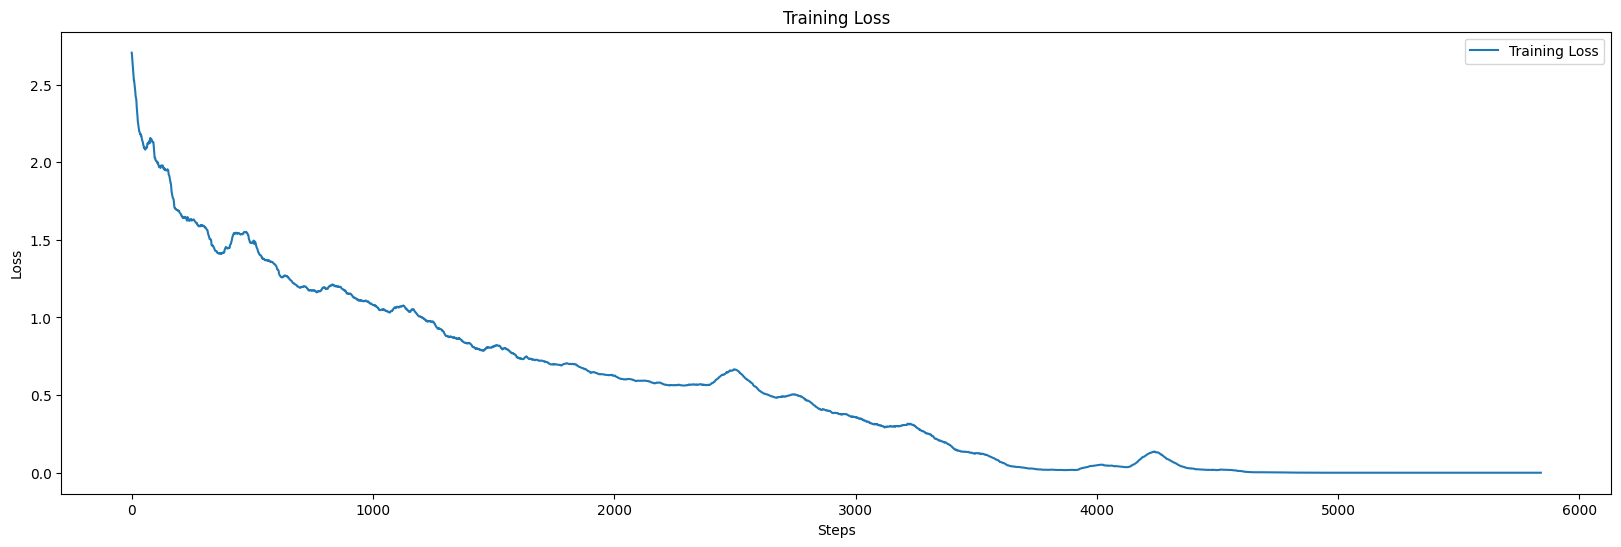

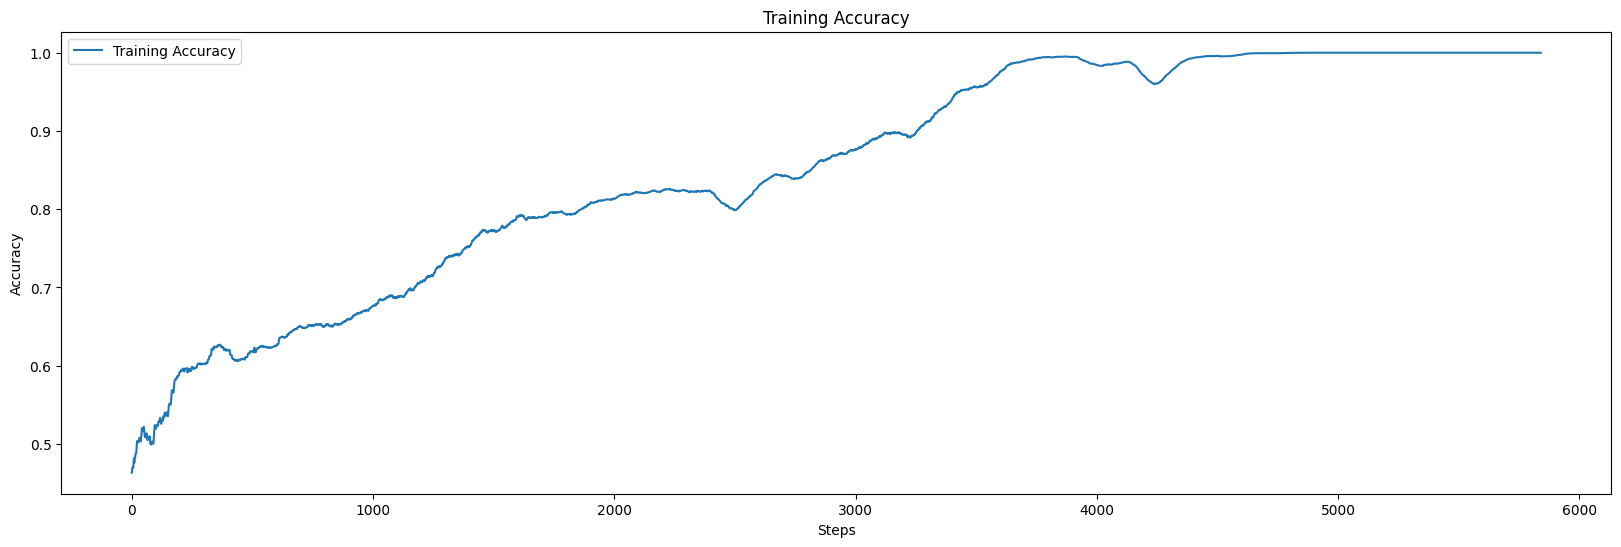

In [20]:
# Plot the loss curve
downsample = 1
window = 100

temp = []
for epoch in losses[num_batches*2::downsample]:
    avg = np.mean(epoch)
    temp.append(avg)
temp = np.convolve(temp, np.ones(window)/window, mode='valid')

plt.figure(figsize=(20, 6))
plt.plot(temp, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# Plot the accuracy curve
temp = []
for epoch in accuracies[num_batches*2::downsample]:
    avg = np.mean(epoch)
    temp.append(avg)
temp = np.convolve(temp, np.ones(window)/window, mode='valid')

plt.figure(figsize=(20, 6))
plt.plot(temp, label="Training Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.show()

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


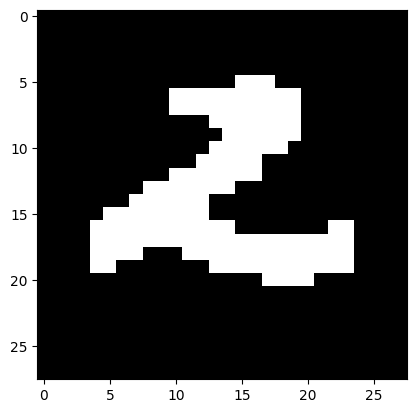

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [21]:
entry_num = num_ex - 100
offset = entry_num * ex_len
data = train_data[offset:offset+ex_len].cpu().numpy()

lbl_1 = data[0:lbl_len]
img = data[lbl_len:lbl_len+img_len]
lbl_2 = data[lbl_len+img_len:]

print(lbl_1)
img = decode_patches(img, 2)
plt.imshow(img, cmap='gray')
plt.show()
print(lbl_2)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


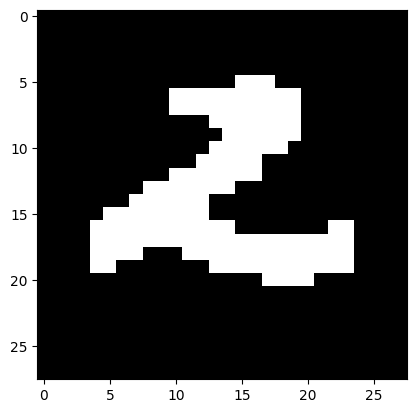

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [23]:
entry_num = num_ex - 100
offset = entry_num * ex_len
abs_indices = torch.arange(offset, offset+ex_len, device=device)
data_indices = abs_indices % ex_len
ex_indices = abs_indices // ex_len
ex_indices = ex_indices * 256
indices = ex_indices + data_indices
with torch.no_grad():
    outputs = model(indices)
    outputs = torch.argmax(outputs, dim=1)

outputs = outputs.cpu().numpy()
lbl_1 = outputs[0:lbl_len]
img = outputs[lbl_len:lbl_len+img_len]
lbl_2 = outputs[lbl_len+img_len:]

print(lbl_1)
img = decode_patches(img, 2)
plt.imshow(img, cmap='gray')
plt.show()
print(lbl_2)

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


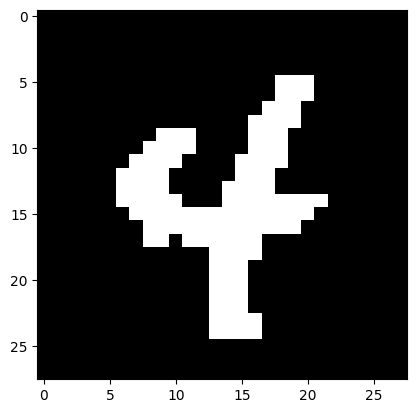

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
----------------------------------------------------------------------------------------------------
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


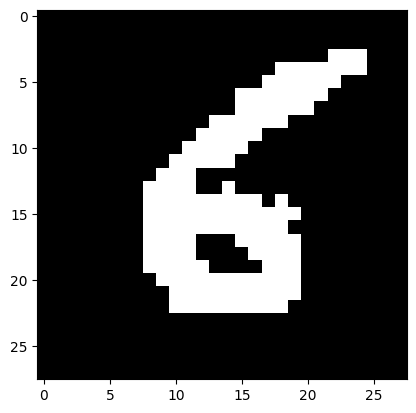

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
----------------------------------------------------------------------------------------------------
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


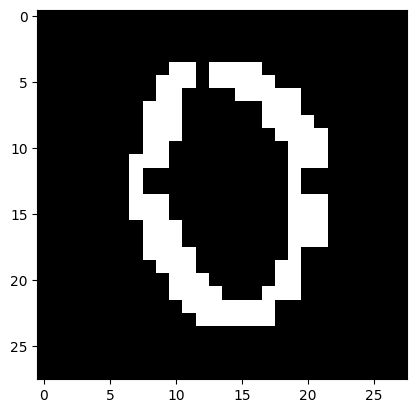

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


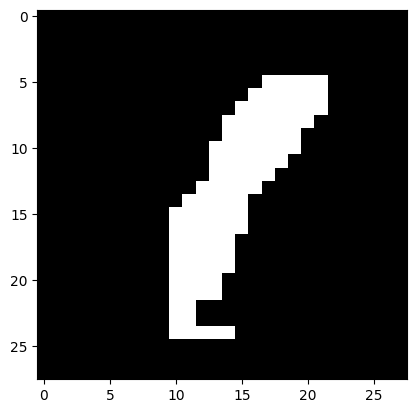

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


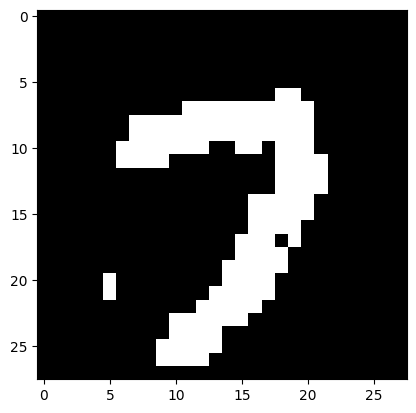

[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
----------------------------------------------------------------------------------------------------
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


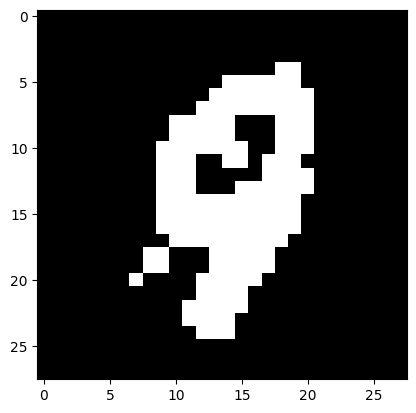

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
----------------------------------------------------------------------------------------------------
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


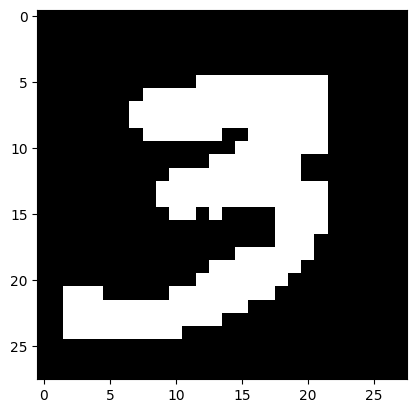

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
----------------------------------------------------------------------------------------------------
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


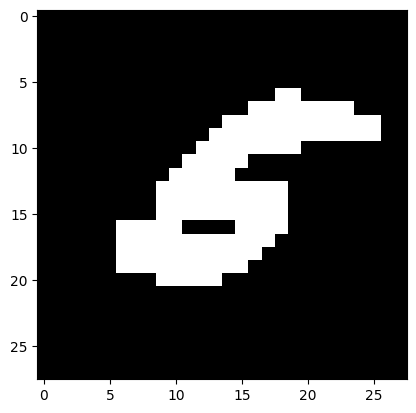

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
----------------------------------------------------------------------------------------------------
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


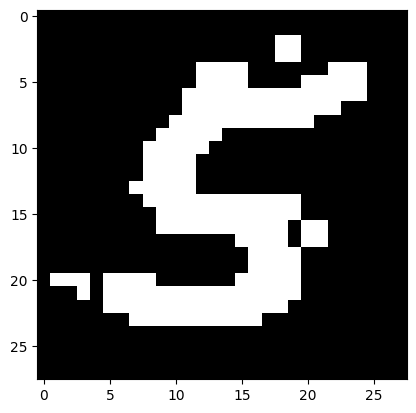

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
----------------------------------------------------------------------------------------------------
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


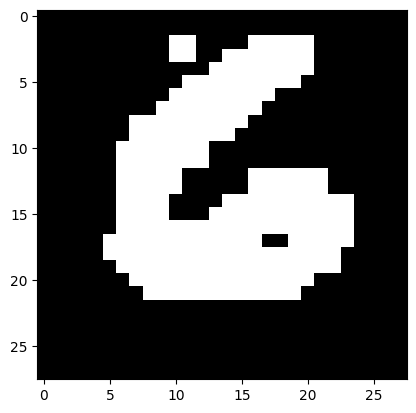

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
----------------------------------------------------------------------------------------------------
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


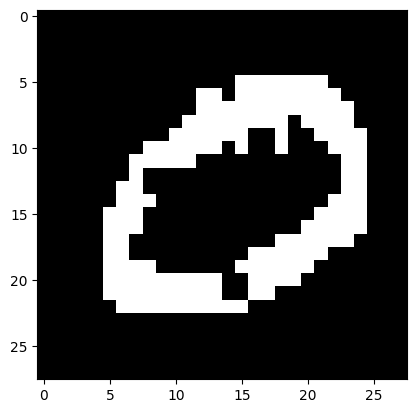

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
----------------------------------------------------------------------------------------------------
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


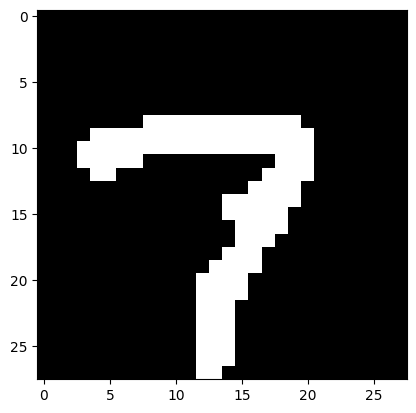

[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
----------------------------------------------------------------------------------------------------
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


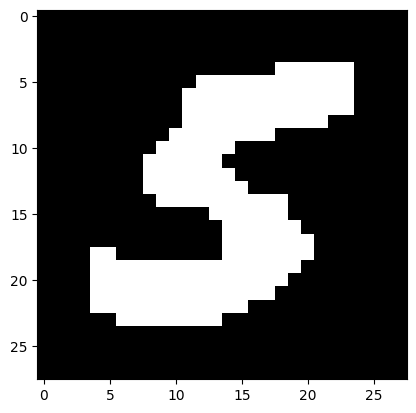

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
----------------------------------------------------------------------------------------------------
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


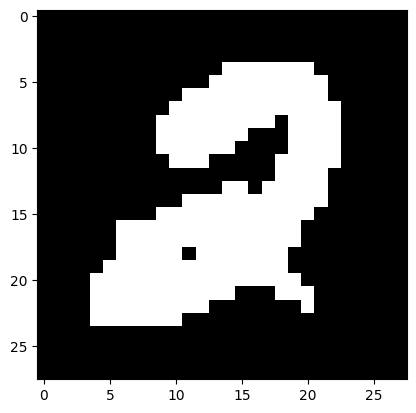

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
----------------------------------------------------------------------------------------------------
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


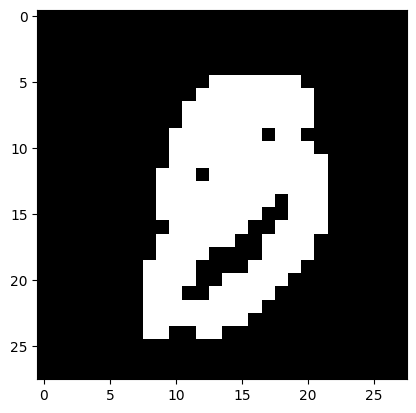

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
----------------------------------------------------------------------------------------------------
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


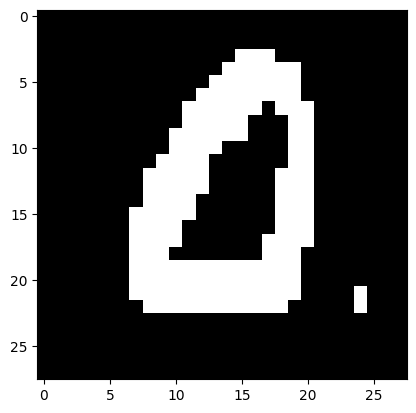

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


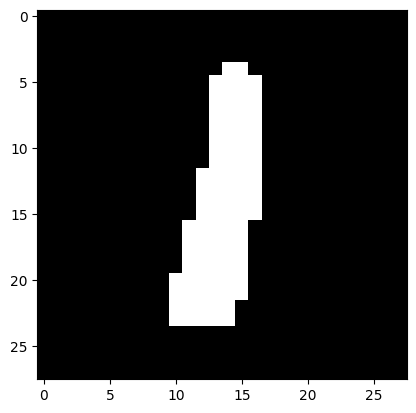

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


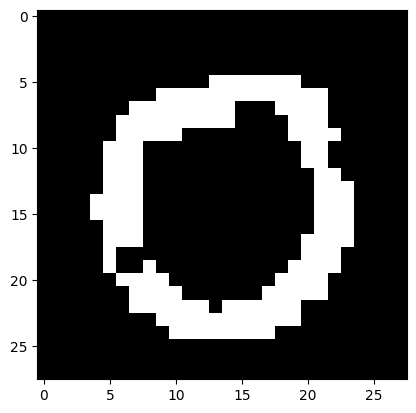

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


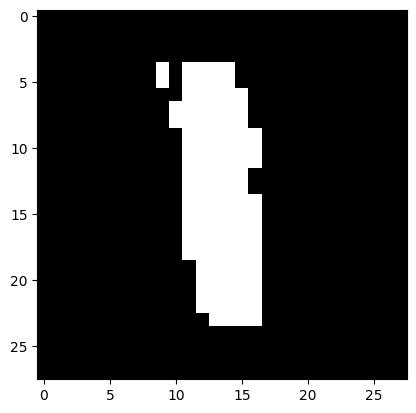

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


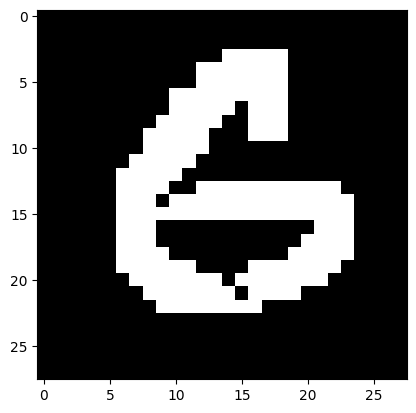

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
----------------------------------------------------------------------------------------------------
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


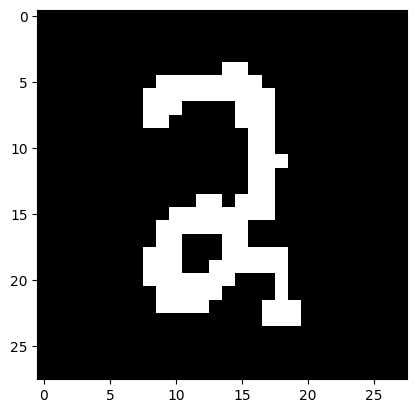

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
----------------------------------------------------------------------------------------------------
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


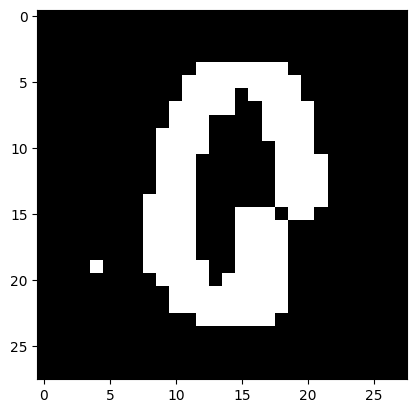

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
----------------------------------------------------------------------------------------------------
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


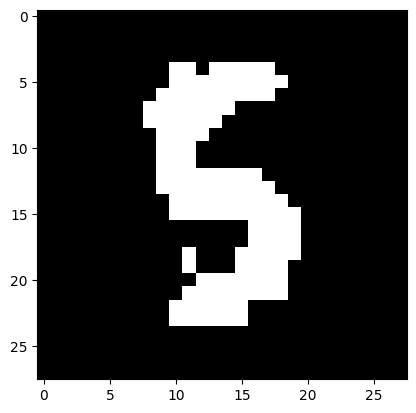

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
----------------------------------------------------------------------------------------------------
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


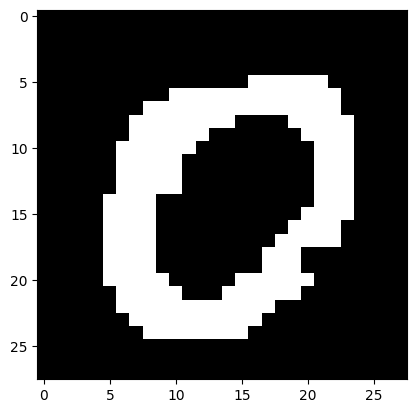

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
----------------------------------------------------------------------------------------------------
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


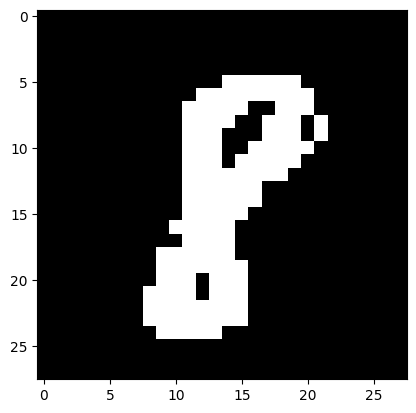

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
----------------------------------------------------------------------------------------------------
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


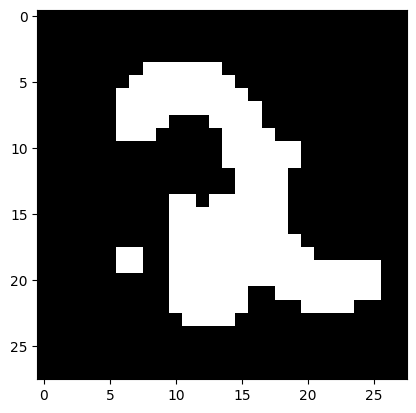

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
----------------------------------------------------------------------------------------------------
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


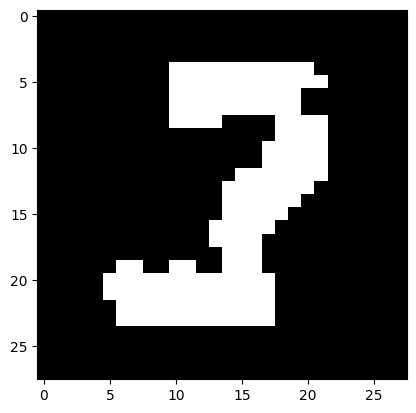

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
----------------------------------------------------------------------------------------------------
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


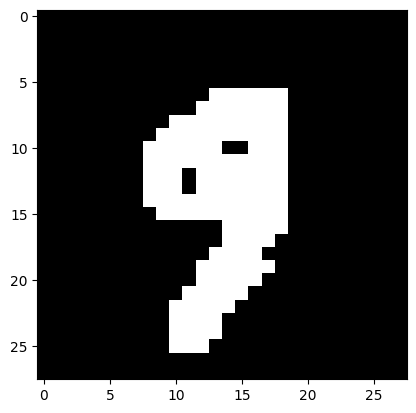

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
----------------------------------------------------------------------------------------------------
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


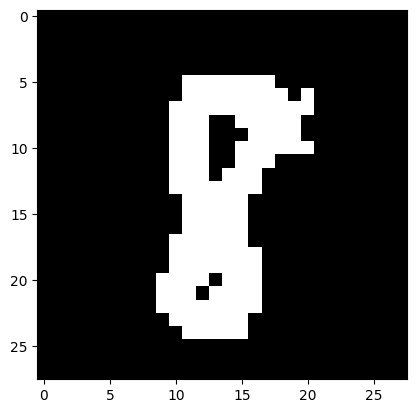

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
----------------------------------------------------------------------------------------------------
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


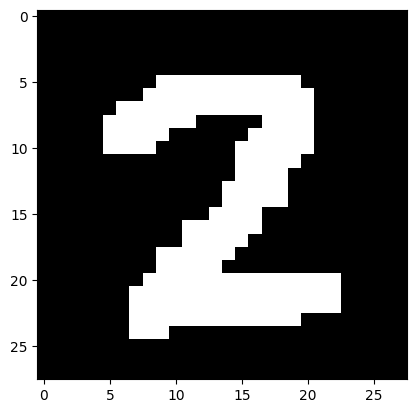

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


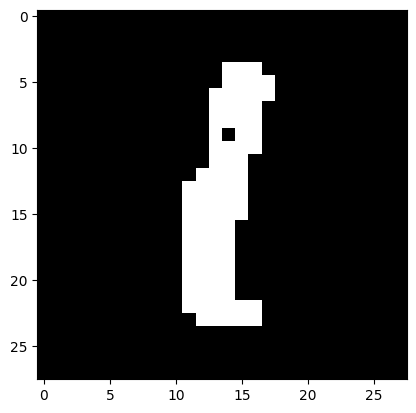

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


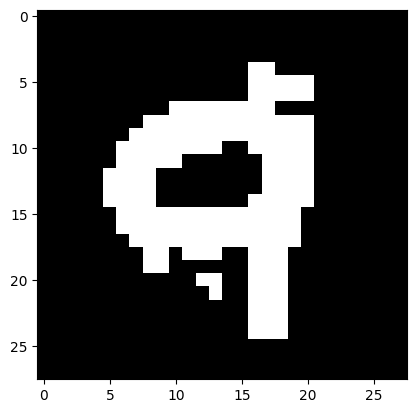

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
----------------------------------------------------------------------------------------------------
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


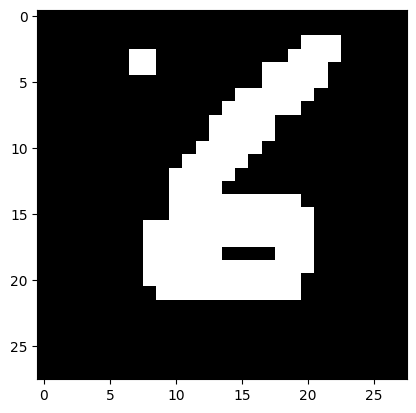

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
----------------------------------------------------------------------------------------------------
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


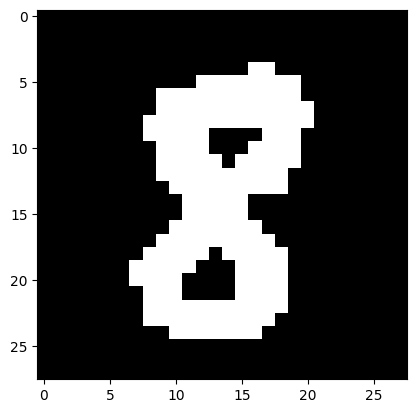

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
----------------------------------------------------------------------------------------------------
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


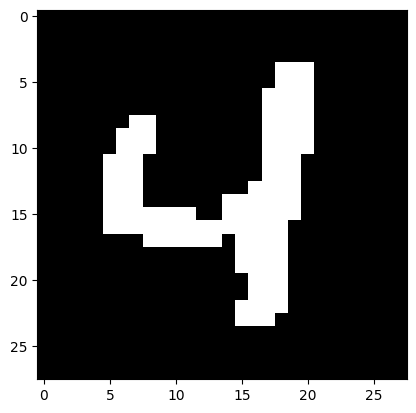

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
----------------------------------------------------------------------------------------------------
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


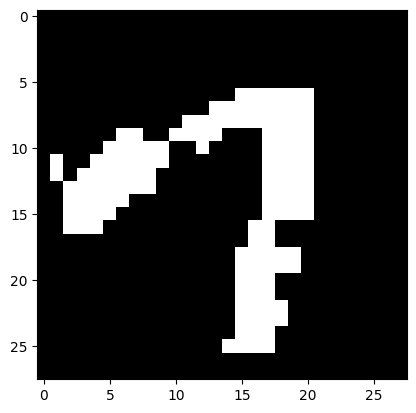

[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


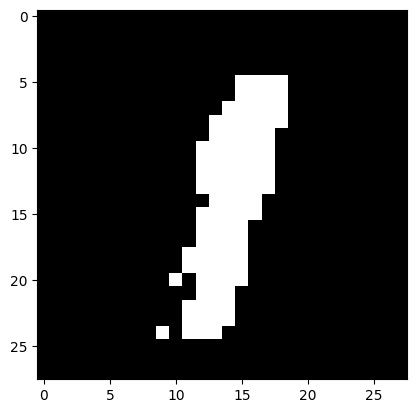

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


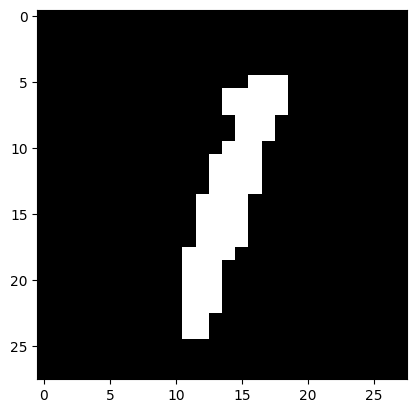

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


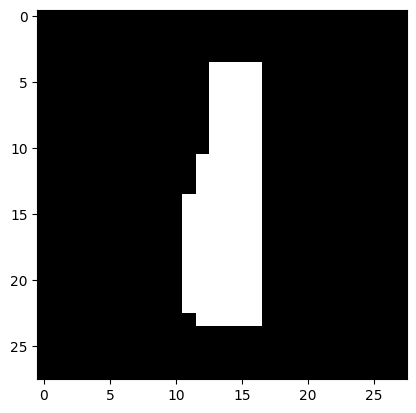

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


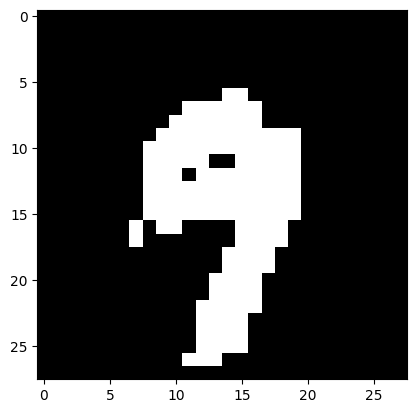

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


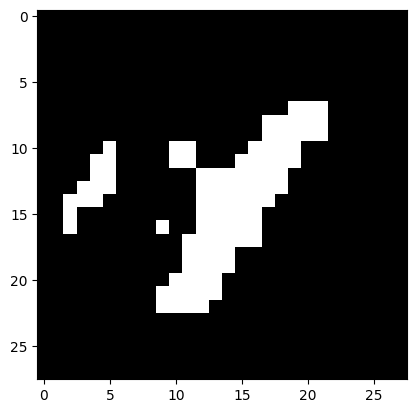

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


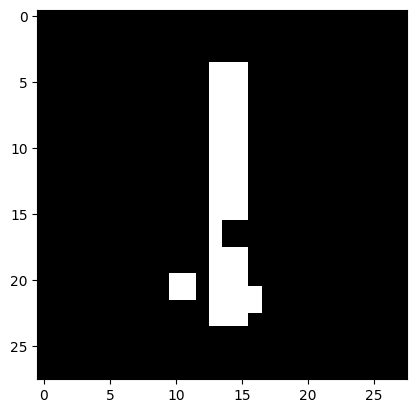

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


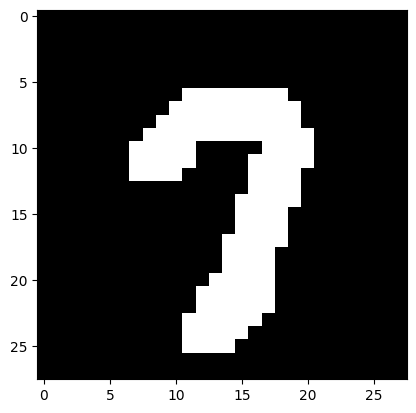

[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
----------------------------------------------------------------------------------------------------
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


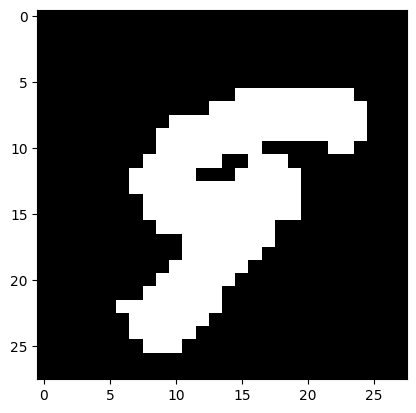

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
----------------------------------------------------------------------------------------------------
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


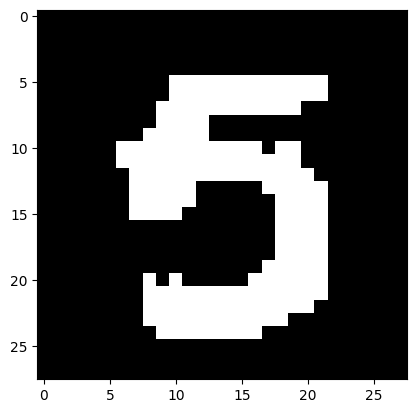

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


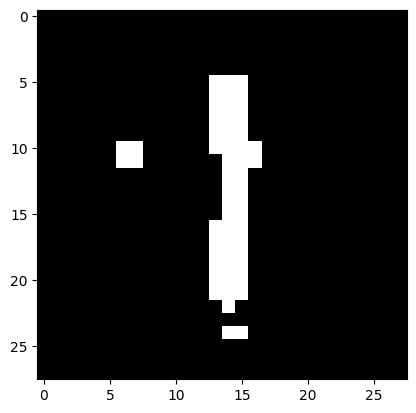

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


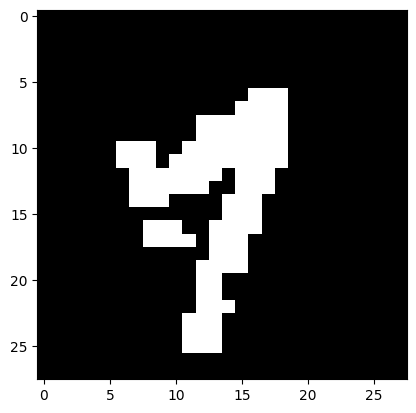

[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
----------------------------------------------------------------------------------------------------
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


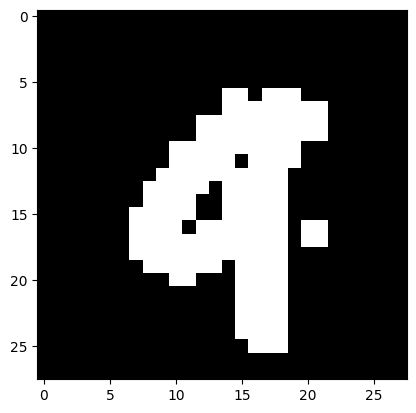

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
----------------------------------------------------------------------------------------------------
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


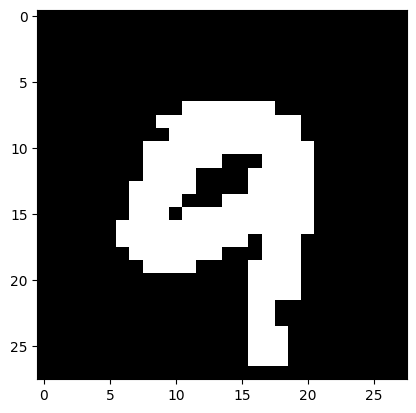

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
----------------------------------------------------------------------------------------------------
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


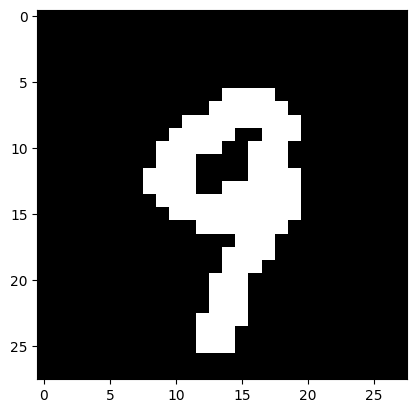

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
----------------------------------------------------------------------------------------------------
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


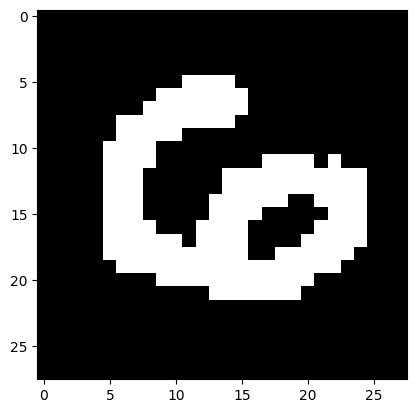

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


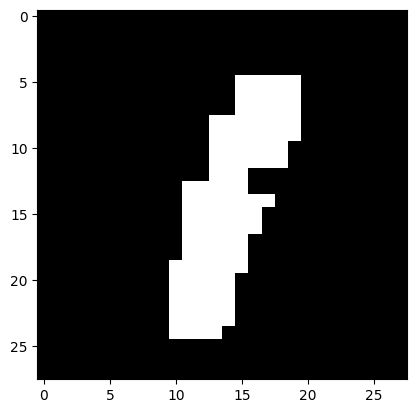

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


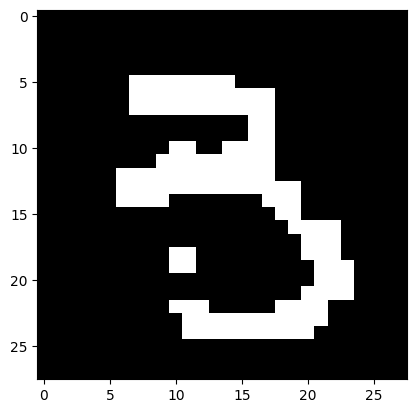

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
----------------------------------------------------------------------------------------------------
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


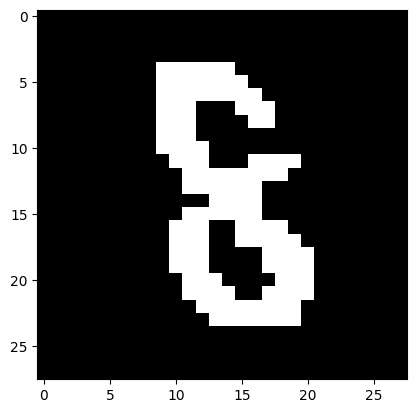

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


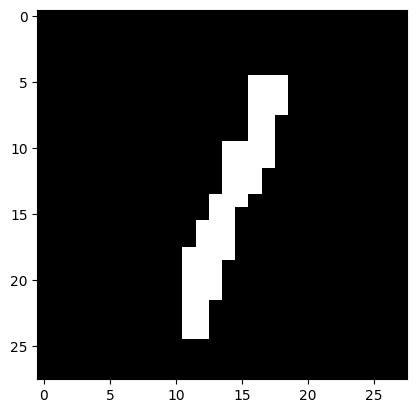

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


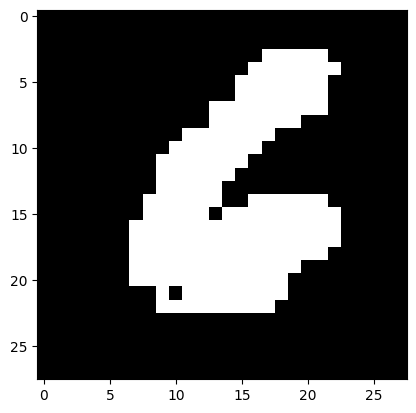

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
----------------------------------------------------------------------------------------------------
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


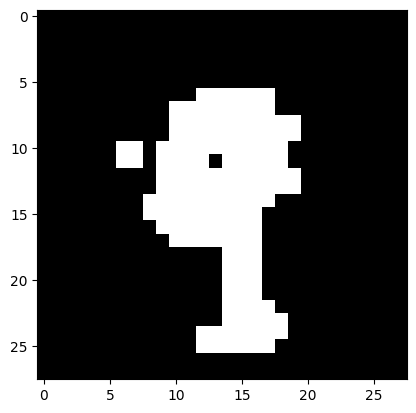

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
----------------------------------------------------------------------------------------------------
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


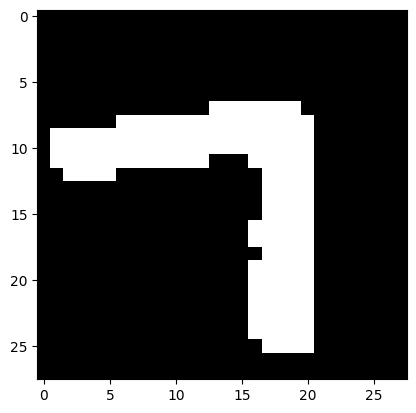

[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
----------------------------------------------------------------------------------------------------
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


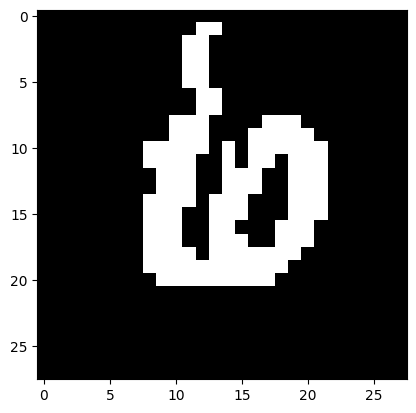

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
----------------------------------------------------------------------------------------------------
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


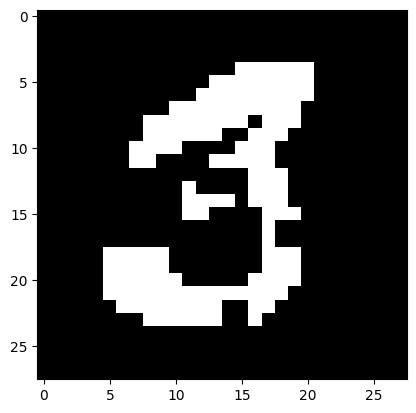

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
----------------------------------------------------------------------------------------------------
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


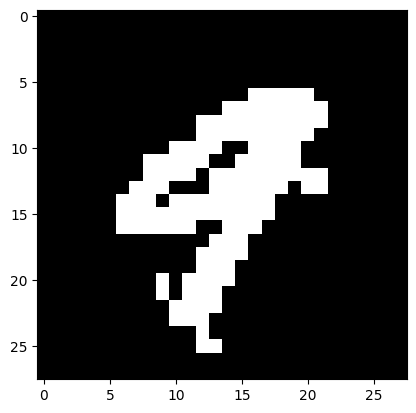

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
----------------------------------------------------------------------------------------------------
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


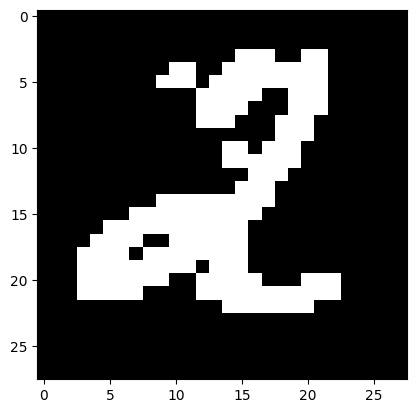

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
----------------------------------------------------------------------------------------------------
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


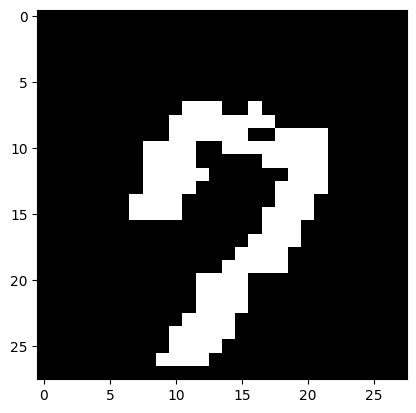

[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
----------------------------------------------------------------------------------------------------
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


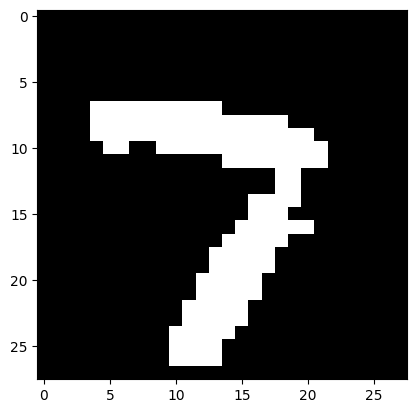

[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
----------------------------------------------------------------------------------------------------
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


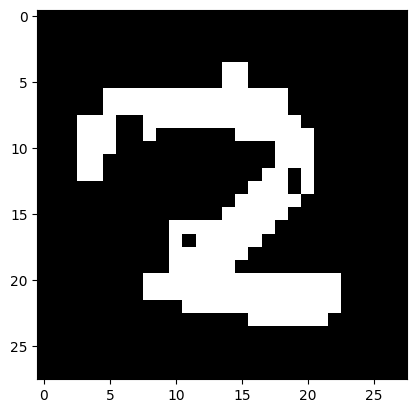

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
----------------------------------------------------------------------------------------------------
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


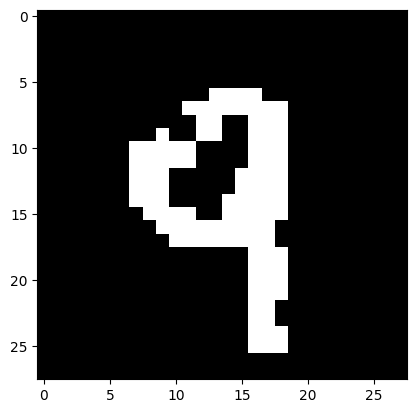

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
----------------------------------------------------------------------------------------------------
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


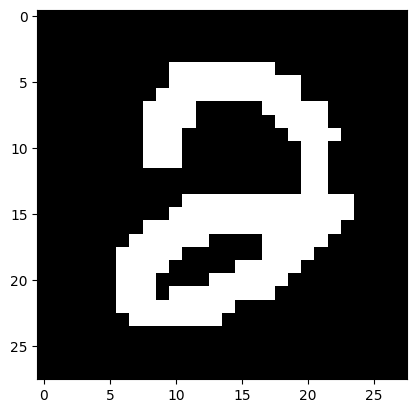

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
----------------------------------------------------------------------------------------------------
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


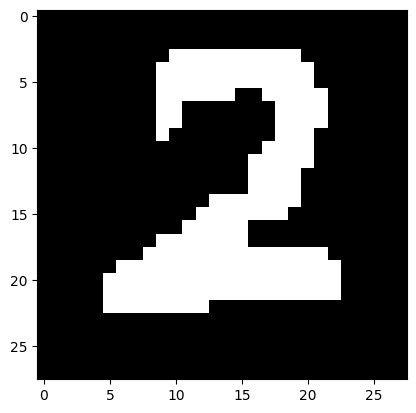

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
----------------------------------------------------------------------------------------------------
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


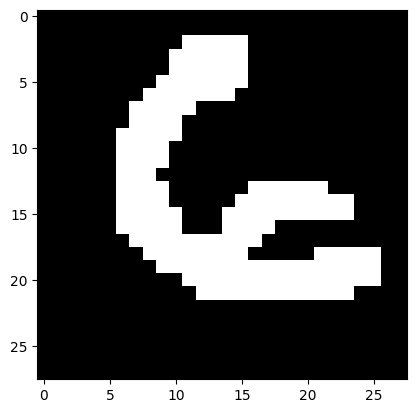

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
----------------------------------------------------------------------------------------------------
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


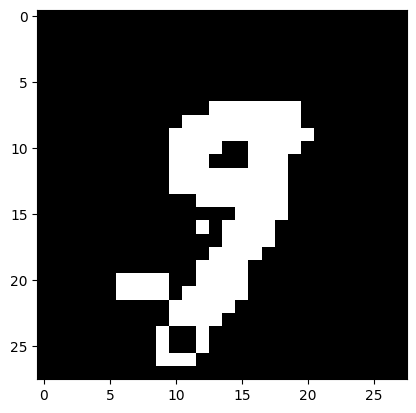

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
----------------------------------------------------------------------------------------------------
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


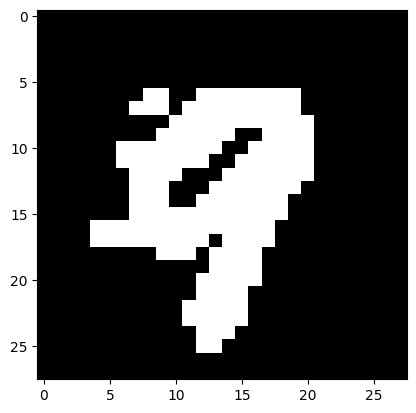

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
----------------------------------------------------------------------------------------------------
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


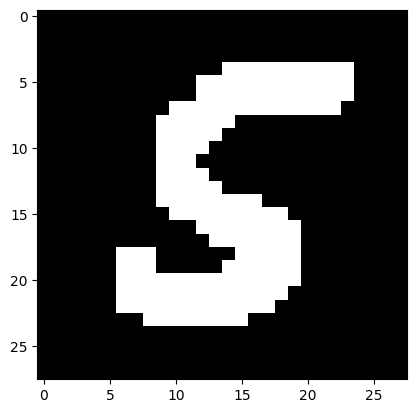

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
----------------------------------------------------------------------------------------------------
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


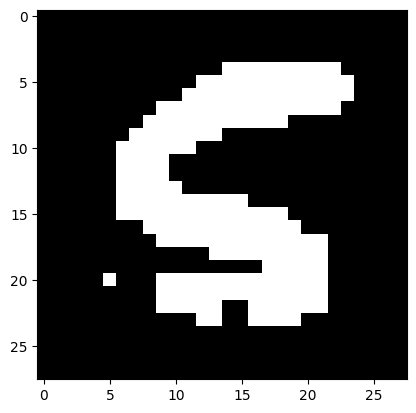

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


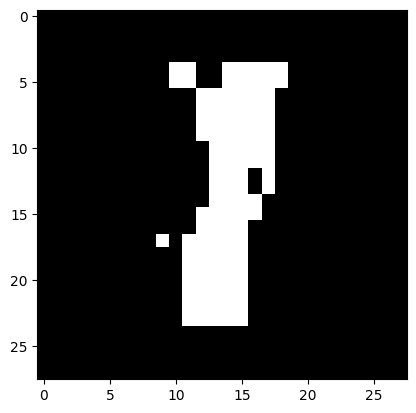

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


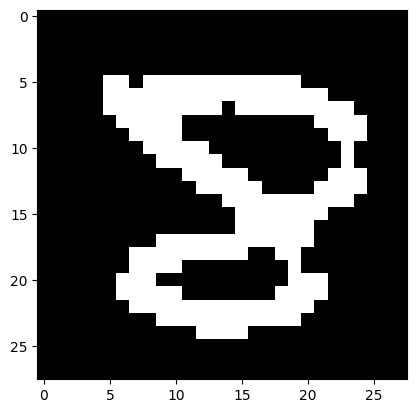

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
----------------------------------------------------------------------------------------------------
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


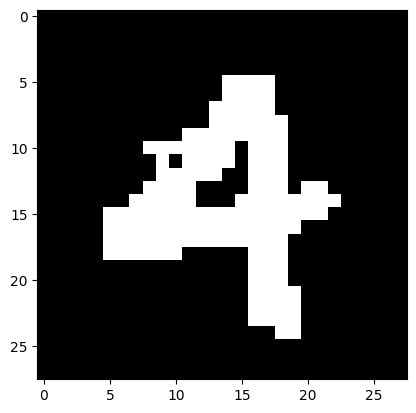

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
----------------------------------------------------------------------------------------------------
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


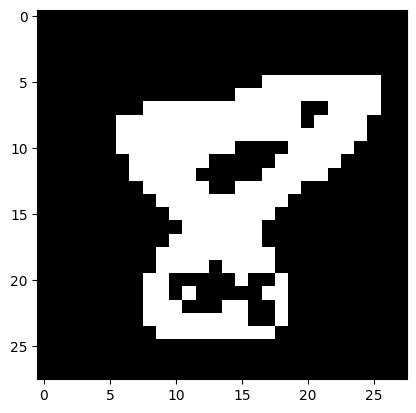

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
----------------------------------------------------------------------------------------------------
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


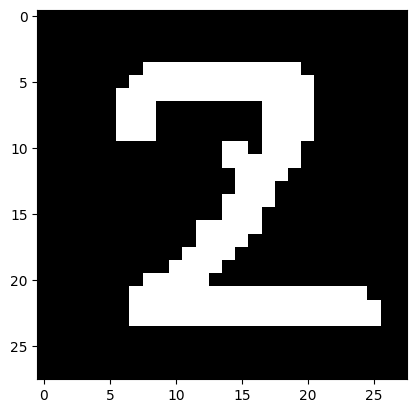

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
----------------------------------------------------------------------------------------------------
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


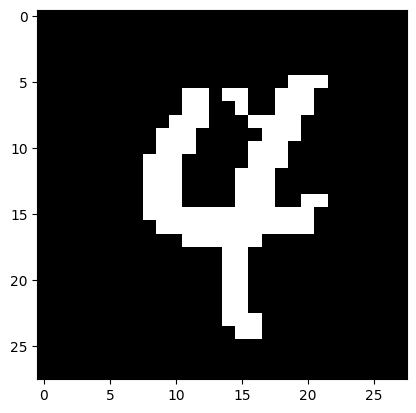

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
----------------------------------------------------------------------------------------------------
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


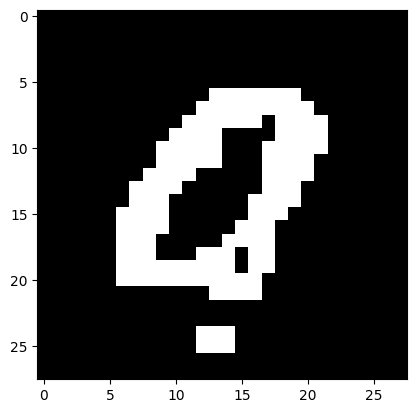

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
----------------------------------------------------------------------------------------------------
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


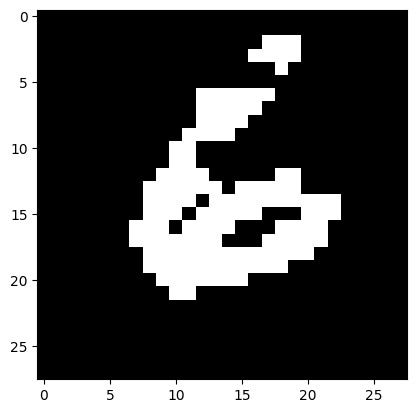

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
----------------------------------------------------------------------------------------------------
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


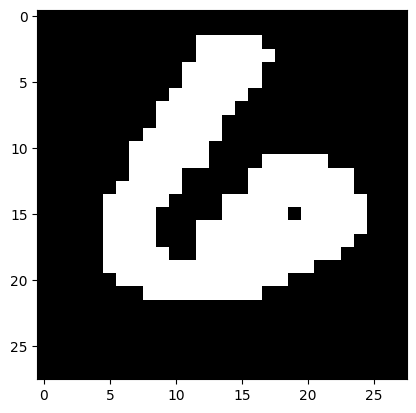

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
----------------------------------------------------------------------------------------------------
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


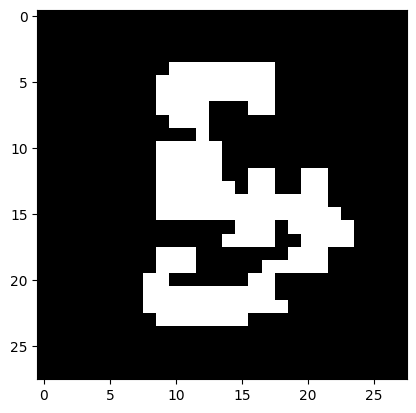

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


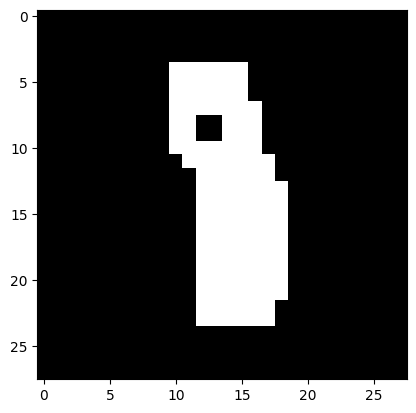

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


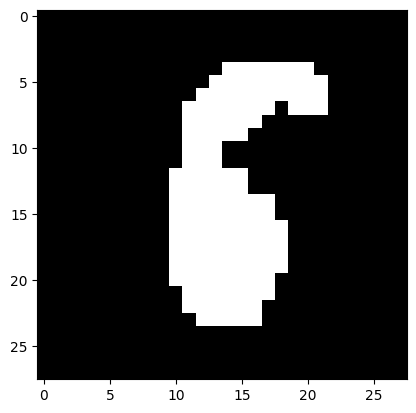

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


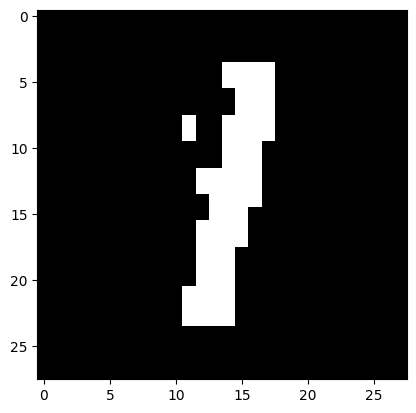

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


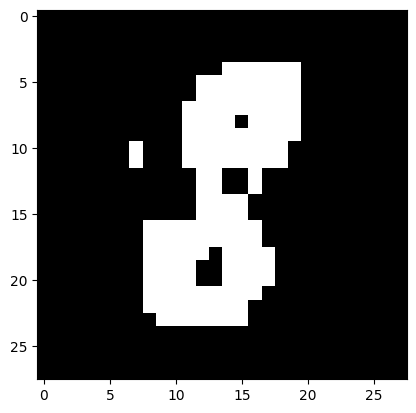

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


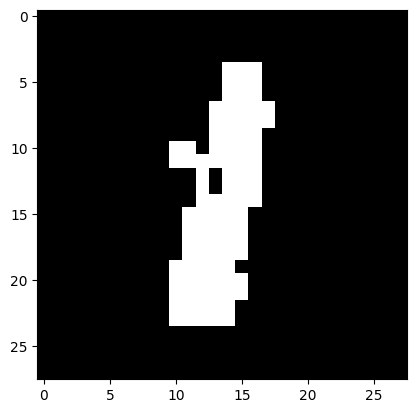

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


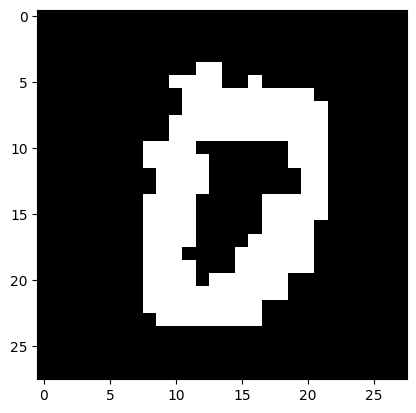

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
----------------------------------------------------------------------------------------------------
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


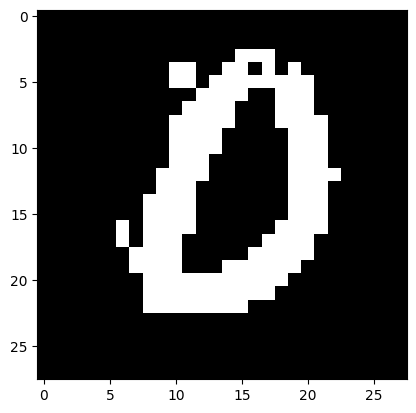

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
----------------------------------------------------------------------------------------------------
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


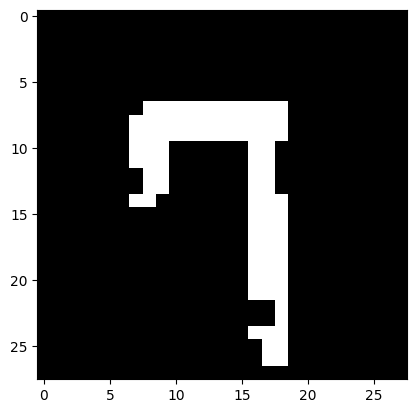

[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
----------------------------------------------------------------------------------------------------
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


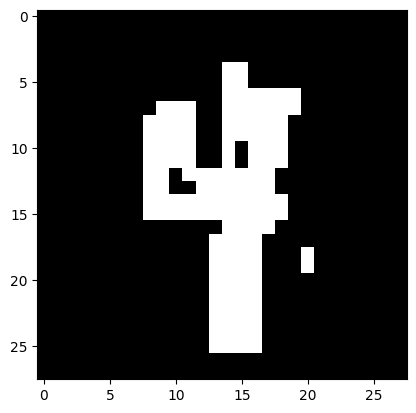

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
----------------------------------------------------------------------------------------------------
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


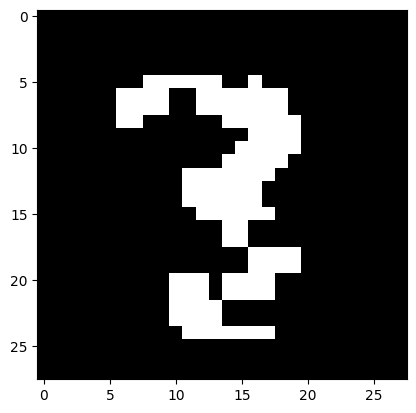

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
----------------------------------------------------------------------------------------------------
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


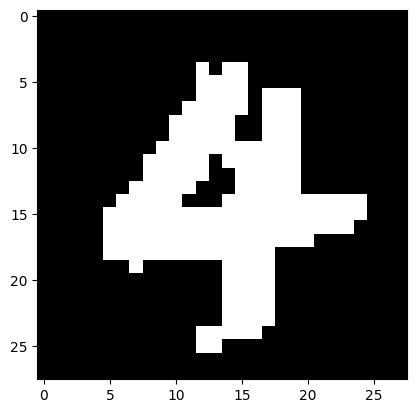

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
----------------------------------------------------------------------------------------------------
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


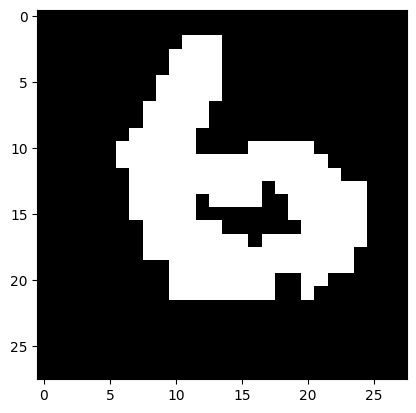

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


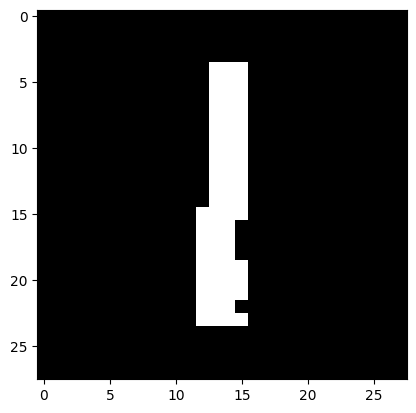

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


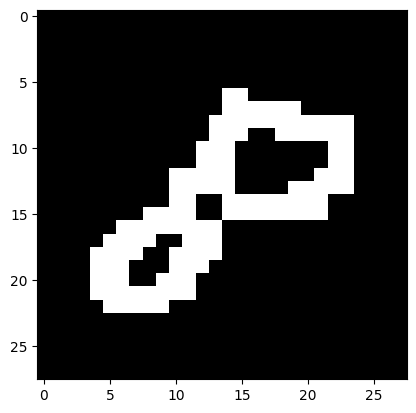

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
----------------------------------------------------------------------------------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


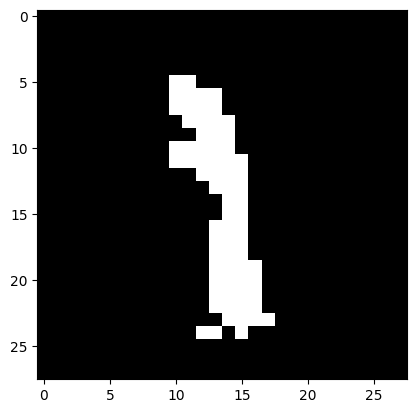

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


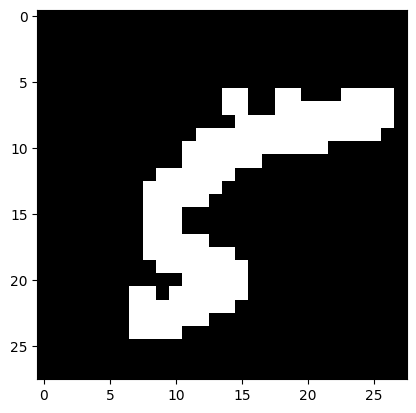

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
----------------------------------------------------------------------------------------------------
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


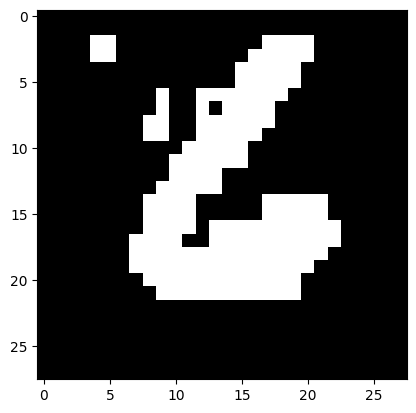

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
----------------------------------------------------------------------------------------------------


In [25]:
for i in range(100):
    entry_num = num_ex+100+i #unseen data
    offset = entry_num * ex_len
    abs_indices = torch.arange(offset, offset+ex_len, device=device)
    data_indices = abs_indices % ex_len
    ex_indices = abs_indices // ex_len
    ex_indices = ex_indices * 256
    indices = ex_indices + data_indices
    with torch.no_grad():
        outputs = model(indices)
        outputs = torch.argmax(outputs, dim=1)

    outputs = outputs.cpu().numpy()
    lbl_1 = outputs[0:lbl_len]
    img = outputs[lbl_len:lbl_len+img_len]
    lbl_2 = outputs[lbl_len+img_len:]

    print(lbl_1)
    img = decode_patches(img, 2)
    plt.imshow(img, cmap='gray')
    plt.show()
    print(lbl_2)
    print('-'*100)